In [ ]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !pip install JQuantumFlow==0.0.5

import torch
import torchvision
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.extensions import XGate, UnitaryGate

import qiskit

from JQuantumFlow.training.lib_dataloader import load_data,to_quantum_matrix,ToQuantumData
from JQuantumFlow.circuit.lib_gate import ExtendGate
from JQuantumFlow.circuit.lib_qiskit_commons import fire_ibmq,analyze

In [ ]:

################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
img_size = 4
 # how many samples per batch 
batch_size = 1 
inference_batch_size = 1


################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
else: 
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'

################ Zhirui on 12-30-2020 ################
#load data and do data preparation
######################################################

train_loader, test_loader = load_data(interest_num,data_path,False,img_size,batch_size,inference_batch_size,False)

for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    to_quantum_data = ToQuantumData(img_size)
    quantum_data = to_quantum_data(data)
    break


Batch Id: 0, Target: tensor([1])


In [ ]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization
weight_1_1 = torch.tensor([1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])

weight_2_1 = torch.tensor([1.,  -1.])
norm_flag_1 = True
norm_para_1 = torch.tensor(0.3060)

weight_2_2 = torch.tensor([-1.,  -1.])
norm_flag_2 = False
norm_para_2 = torch.tensor(0.6940)

1.9.0


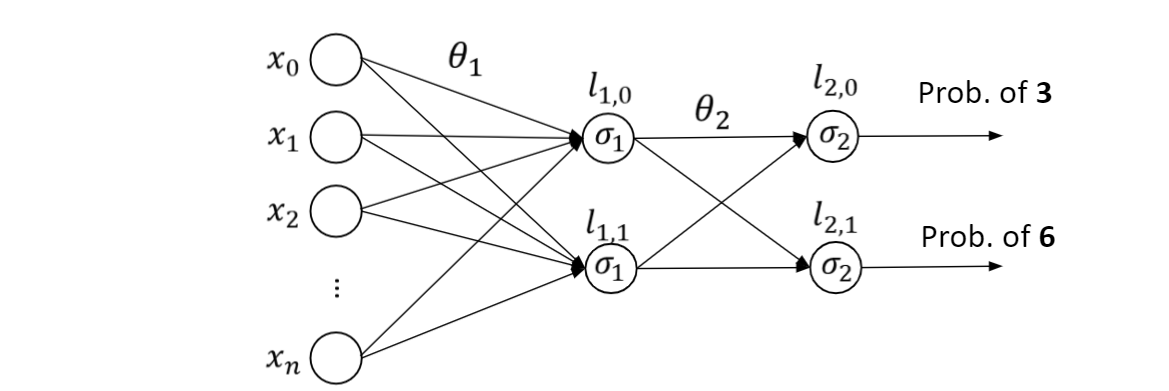

In [ ]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation
######################################################

# From Listing 2: creat the qubits to hold data
inp_1 = QuantumRegister(4,"in1_qbit")
inp_2 = QuantumRegister(4,"in2_qbit")
circ = QuantumCircuit(inp_1,inp_2)
data_matrix = quantum_matrix
circ.append(UnitaryGate(data_matrix, label="Input"), inp_1[0:4])
circ.append(UnitaryGate(data_matrix, label="Input"), inp_2[0:4])

# From Listing 3: create auxiliary qubits
aux = QuantumRegister(2,"aux_qbit")
circ.add_register(aux)

# From Listing 4: create output qubits for the first layer (hidden neurons)
hidden_neurons = QuantumRegister(2,"hidden_qbits")
circ.add_register(hidden_neurons)


# From Listing 3: to multiply inputs and weights on quantum circuit
if weight_1_1.sum()<0:
    weight_1_1 = weight_1_1*-1
idx = 0
for idx in range(weight_1_1.flatten().size()[0]):
    if weight_1_1[idx]==-1:
        state = "{0:b}".format(idx).zfill(4)
        ExtendGate.neg_weight_gate(circ,inp_1,aux,state)
        circ.barrier()

if weight_1_2.sum()<0:
    weight_1_2 = weight_1_2*-1
idx = 0
for idx in range(weight_1_2.flatten().size()[0]):
    if weight_1_2[idx]==-1:
        state = "{0:b}".format(idx).zfill(4)
        ExtendGate.neg_weight_gate(circ,inp_2,aux,state)
        circ.barrier()
        
# From Listing 4: applying the quadratic function on the weighted sum
circ.h(inp_1)
circ.x(inp_1)
ExtendGate.ccccx(circ,inp_1[0],inp_1[1],inp_1[2],inp_1[3],hidden_neurons[0],aux[0],aux[1])

circ.h(inp_2)
circ.x(inp_2)
ExtendGate.ccccx(circ,inp_2[0],inp_2[1],inp_2[2],inp_2[3],hidden_neurons[1],aux[0],aux[1])


print("Hidden layer created!")

state 1 0111
state 2 1110
state 1 1001
state 2 1001
state 1 1011
state 2 1101
state 1 1001
state 2 1001
state 1 1011
state 2 1101
Hidden layer created!


In [ ]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf
######################################################

inter_q_1 = QuantumRegister(1,"inter_q_1_qbits")
norm_q_1 = QuantumRegister(1,"norm_q_1_qbits")
out_q_1 = QuantumRegister(1,"out_q_1_qbits")
circ.add_register(inter_q_1,norm_q_1,out_q_1)

circ.barrier()

if weight_2_1.sum()<0:
    weight_2_1 = weight_2_1*-1
idx = 0
for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        circ.x(hidden_neurons[idx])
circ.h(inter_q_1)
circ.cz(hidden_neurons[0],inter_q_1)
circ.x(inter_q_1)
circ.cz(hidden_neurons[1],inter_q_1)
circ.x(inter_q_1)
circ.h(inter_q_1)
circ.x(inter_q_1)

circ.barrier()

norm_init_rad = float(norm_para_1.sqrt().arcsin()*2)
circ.ry(norm_init_rad,norm_q_1)
if norm_flag_1:
    circ.cx(inter_q_1,out_q_1)
    circ.x(inter_q_1)
    circ.ccx(inter_q_1,norm_q_1,out_q_1)
else:
    circ.ccx(inter_q_1,norm_q_1,out_q_1)

for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        circ.x(hidden_neurons[idx])

circ.barrier()




inter_q_2 = QuantumRegister(1,"inter_q_2_qbits")
norm_q_2 = QuantumRegister(1,"norm_q_2_qbits")
out_q_2 = QuantumRegister(1,"out_q_2_qbits")
circ.add_register(inter_q_2,norm_q_2,out_q_2)

circ.barrier()

if weight_2_2.sum()<0:
    weight_2_2 = weight_2_2*-1
idx = 0
for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        circ.x(hidden_neurons[idx])
circ.h(inter_q_2)
circ.cz(hidden_neurons[0],inter_q_2)
circ.x(inter_q_2)
circ.cz(hidden_neurons[1],inter_q_2)
circ.x(inter_q_2)
circ.h(inter_q_2)
circ.x(inter_q_2)

circ.barrier()

norm_init_rad = float(norm_para_2.sqrt().arcsin()*2)
circ.ry(norm_init_rad,norm_q_2)
if norm_flag_2:
    circ.cx(inter_q_2,out_q_2)
    circ.x(inter_q_2)
    circ.ccx(inter_q_2,norm_q_2,out_q_2)
else:
    circ.ccx(inter_q_2,norm_q_2,out_q_2)

for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        circ.x(hidden_neurons[idx])

circ.barrier()

c_reg = ClassicalRegister(2,"reg")
circ.add_register(c_reg)
circ.measure(out_q_1,c_reg[0])
circ.measure(out_q_2,c_reg[1])

print("Output layer created!")

Output layer created!


In [ ]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

# From Listing 6: execute the quantum circuit to obtain the results
qc_shots=8192
counts = fire_ibmq(circ,qc_shots,True)
(mycount,bits) = analyze(counts)
class_prob=[]
for b in range(bits):
    class_prob.append(float(mycount[b])/qc_shots)


In [ ]:
print(class_prob)
print("Prediction class: {}".format(class_prob.index(max(class_prob))))
print("Target class: {}".format(target[0]))
if class_prob.index(max(class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")

[0.41552734375, 0.5738525390625]
Prediction class: 1
Target class: 1
Correct prediction
